# Bell State Measurement on Various Backends
This exercise will demonstrate the preparation and measurement of a Bell state $|\Phi^+ ⟩ = (|00⟩ + |11⟩)/\sqrt{2}$ on an ideal simulator, a noisy simulator of a real quantum device, and a real quantum device.

## Questions to Answer
1. In Step 3, what happens when we change `optimization_level` to `0` or `2`?
2. Compare the number of measurements across the three execution types. What observations can you make?

If you are interested in the details of transpilation, take a look at [this](https://www.youtube.com/watch?v=MvX5OUK-tbE&list=PLOFEBzvs-Vvr-GzDWlZpAcDpki5jUqYJu&index=3&ab_channel=Qiskit) lecture.

## Setup

We need `qiskit-ibmq-provider` to connect to IBM quantum devices.

In [ ]:
! pip install -q qiskit==1.3.1 qiskit-aer qiskit-ibm-runtime pylatexenc

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

## Step 1: Create a Bell State Circuit


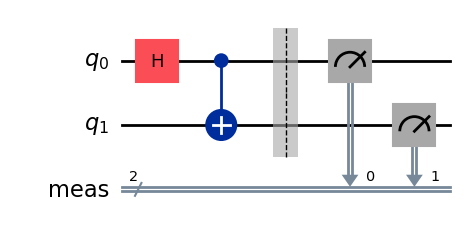

In [ ]:
# Create a Quantum Circuit with 2 qubits and 2 classical bits
bell = QuantumCircuit(2)

# Apply a Hadamard gate to qubit 0
bell.h(0)

# Apply a CNOT gate with qubit 0 as control and qubit 1 as target
bell.cx(0, 1)

# Measure all qubits
bell.measure_all()

# Display the circuit
bell.draw('mpl')

## Step 2: Simulating on an Ideal Quantum Computer

{'11': 513, '00': 511}


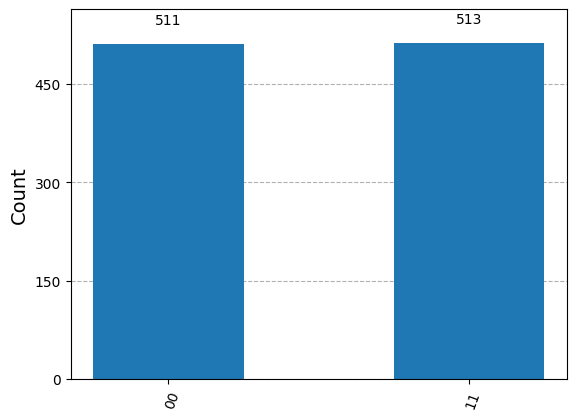

In [ ]:
# Initialize simulator
simulator = AerSimulator(method="automatic")

# Execute the circuit and extract the measurement counts
execution_result = simulator.run(bell, shots=1024).result()
counts = execution_result.get_counts()
print(counts)

# Plot the measurement results
plot_histogram(counts)

## Step 3: Simulating on a Noisy Quantum Device
Let's simulate the results of this circuit using the noise model from an actual hardware. Let's use [Brisbane device](https://quantum.ibm.com/services/resources?system=ibm_brisbane) (we will take a set of native gates right from this link). You can find your IBM Quantum Platform API token [here](https://quantum.ibm.com/).

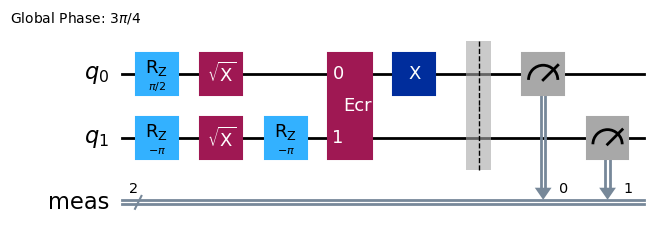

In [ ]:
# Import the QiskitRuntimeService from the qiskit_ibm_runtime module
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.primitives import SamplerV2

# Initialize the Qiskit runtime service provider using IBM Quantum credentials
provider = QiskitRuntimeService(
    channel='ibm_quantum',
    token='Insert IBM Quantum Platform API Token Here')

# Select the IBM Quantum backend to use for execution (in this case, "ibm_brisbane")
backend = provider.backend("ibm_brisbane")

# Create a sampler instance from the selected backend
sampler = SamplerV2.from_backend(backend)

# Transpile the Bell state circuit using an AerSimulator with the noise model of actual hardware.
# The basis gates are specified to match those available on the real hardware.
# Optmization level controls efficiency of the circuit.
bell_t = transpile(bell, AerSimulator(basis_gates=["ecr", "id", "rz", "sx", "x"]), optimization_level=1)

# Display the circuit
bell_t.draw('mpl')

{'00': 463, '11': 439, '01': 64, '10': 58}


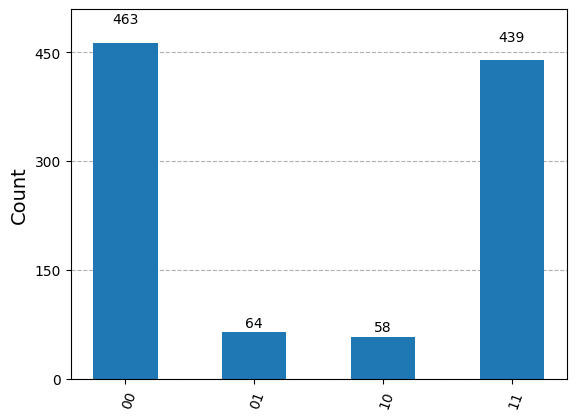

In [ ]:
# Run the transpiled Bell state circuit on the selected backend with 1024 shots
job_result = sampler.run([bell_t], shots=1024).result()

# Extract the measurement counts from the job result
counts = job_result[0].data.meas.get_counts()

# Print the measurement results (qubit state counts)
print(counts)

# Plot the measurement results
plot_histogram(counts)

## Step 4: Running on an Actual Quantum Computer

In [ ]:
# Import the function to generate a preset pass manager for circuit optimization
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# Import QiskitRuntimeService for managing IBM Quantum services and SamplerV2 for sampling measurement outcomes
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

In [ ]:
# Get the least busy quantum backend that is operational and not a simulator
backend = provider.least_busy(operational=True, simulator=False)

# Print the name of the selected backend
print(f"Selected backend: {backend.name}")

# Generate a preset pass manager with an optimization level of 1 to optimize the circuit for the selected backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

# Apply the optimization pass manager to the Bell state circuit
isa_circuit = pm.run(bell)

# Initialize a sampler instance for running quantum circuits using the selected backend
sampler = SamplerV2(mode=backend)

# Set the number of measurement shots (repetitions of the experiment) to 1024
sampler.options.default_shots = 1024

# Run the optimized circuit using the sampler and create a job instance
job = sampler.run([isa_circuit])

# Print the unique Job ID to track execution status on the IBM Quantum backend
print(f"Job ID is {job.job_id()}")


Job ID is cyh9ryv9b62g008269fg


{'11': 484, '00': 513, '10': 16, '01': 11}


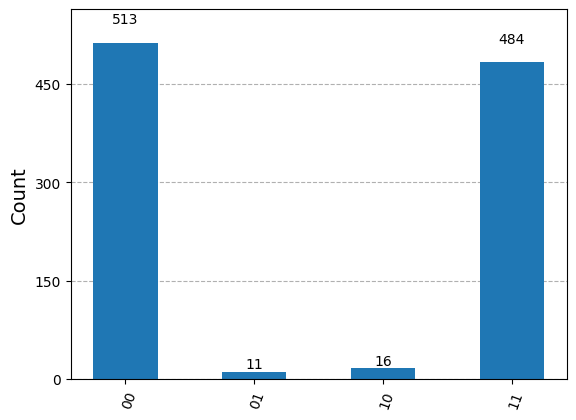

In [ ]:
# To get counts for a particular pub result, use
#
# pub_result = job.result()[<idx>].data.<classical register>.get_counts()
#
# where <idx> is the index of the pub and <classical register> is the name of the classical register.
# You can use circuit.cregs to find the name of the classical registers.

# Extract the measurement counts from the job result
counts = job.result()[0].data.meas.get_counts()

# Print the measurement results (qubit state counts)
print(counts)

# Plot the measurement results
plot_histogram(counts)

The results of the job are stored on IBM servers. You can access the result of the job, if you know the job id.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='Insert IBM Quantum Platform API Token Here'
)
job = service.job('cyh6vbdnrmz0008t58zg')

# Check job status
print(f"Job Status: {job.status()}")

# Get results if job is complete
if job.status() == "DONE":
    # To get counts for a particular pub result, use
    #
    # pub_result = job.result()[<idx>].data.<classical register>.get_counts()
    #
    # where <idx> is the index of the pub and <classical register> is the name of the classical register.
    # You can use circuit.cregs to find the name of the classical registers.

    # Extract the measurement counts from the job result
    counts = job.result()[0].data.meas.get_counts()

    # Print the measurement results (qubit state counts)
    print(counts)
else:
    print("Job is still running or failed.")



Job Status: DONE
{'00': 524, '11': 471, '01': 13, '10': 16}
